2025-09-29 18:45:10,631 - climada.hazard.tc_tracks - WARNING - 174 storm events are discarded because no valid wind/pressure values have been found: 1980290N10088, 1980338N09085, 1982168N23090, 1982196N20069, 1982199N18088, ...
Available keys: KeysView(<xarray.Dataset> Size: 3kB
Dimensions:                 (time: 56)
Coordinates:
  * time                    (time) datetime64[ns] 448B 1981-12-05T06:00:00 .....
    lat                     (time) float32 224B 10.7 10.8 10.8 ... 22.2 22.8
    lon                     (time) float32 224B 87.5 86.8 86.4 ... 88.5 89.1
Data variables:
    radius_max_wind         (time) float32 224B 46.95 45.29 ... 32.48 35.23
    radius_oci              (time) float32 224B 147.0 156.3 ... 190.8 183.7
    max_sustained_wind      (time) float32 224B 20.0 23.0 25.0 ... 45.0 40.0
    central_pressure        (time) float32 224B 1.008e+03 1.006e+03 ... 992.5
    environmental_pressure  (time) float64 448B 1.008e+03 ... 1.005e+03
    time_step               (time) flo

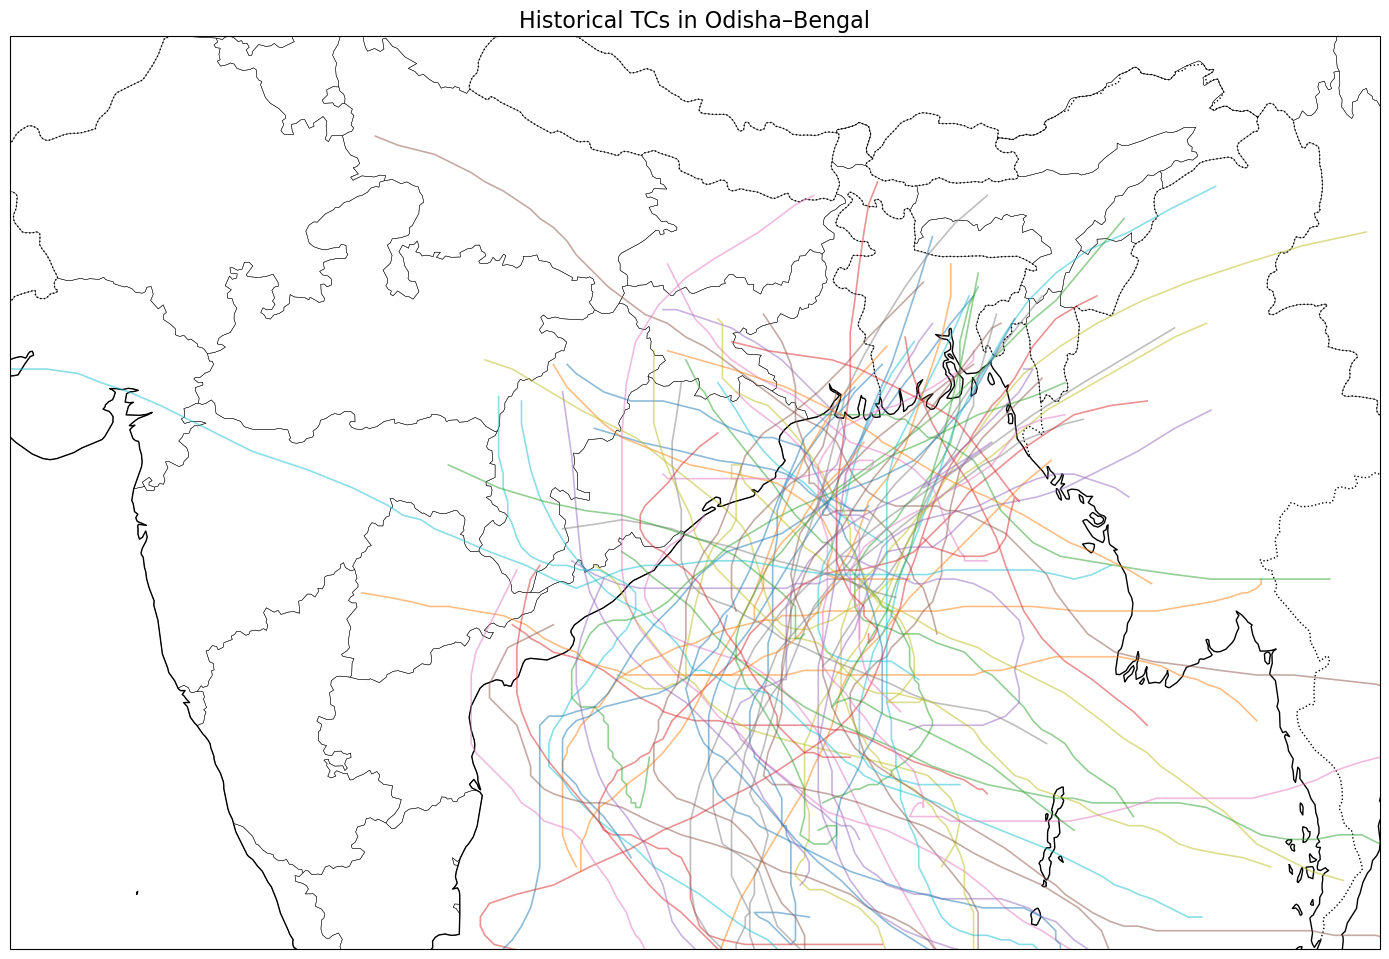

Exposure columns: ['value', 'region_id', 'impf_', 'geometry', 'lat', 'lon']
          value  region_id  impf_                   geometry        lat  \
0  9.015559e+04        356      1  POINT (88.85417 21.60417)  21.604167   
1  1.845753e+05        356      1  POINT (88.85417 21.56250)  21.562500   
2  1.336241e+05        356      1  POINT (88.89583 21.56250)  21.562500   
3  8.487188e+06        356      1  POINT (88.14583 21.85417)  21.854167   
4  5.139400e+06        356      1  POINT (88.10417 21.81250)  21.812500   

         lon  
0  88.854167  
1  88.854167  
2  88.895833  
3  88.145833  
4  88.104167  
Synthetic track name: UNNAMED_gen1
Wind values: [24.         25.2        26.4        27.6        28.4        29.2
 30.         30.         30.         30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         30.         30.         30.         30.         30.
 30.         31.2        32.4        33.6        34.4        35.2
 36.    

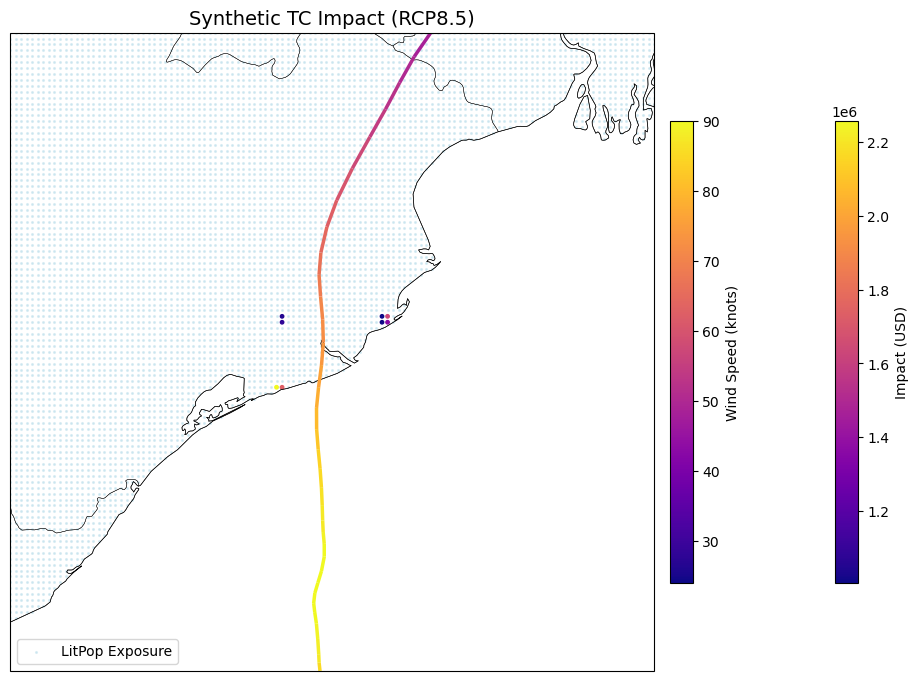

Impact matrix shape: (1, 27754)


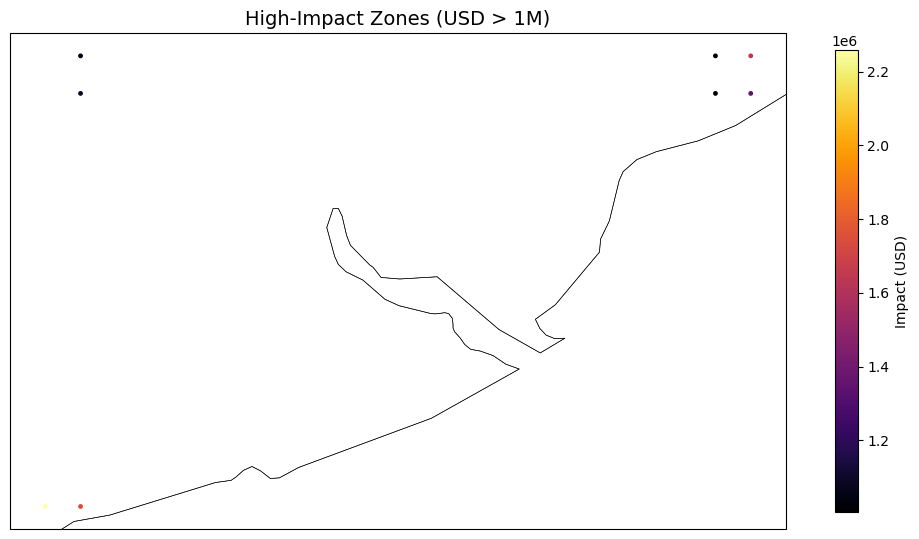

Max impact value (USD): 2257911.9348112345
Number of high-impact zones: 8
Mean impact value (USD): 1390822.3449443756
Impact lat range: 19.8125 - 20.3125
Impact lon range: 85.8125 - 86.64583333


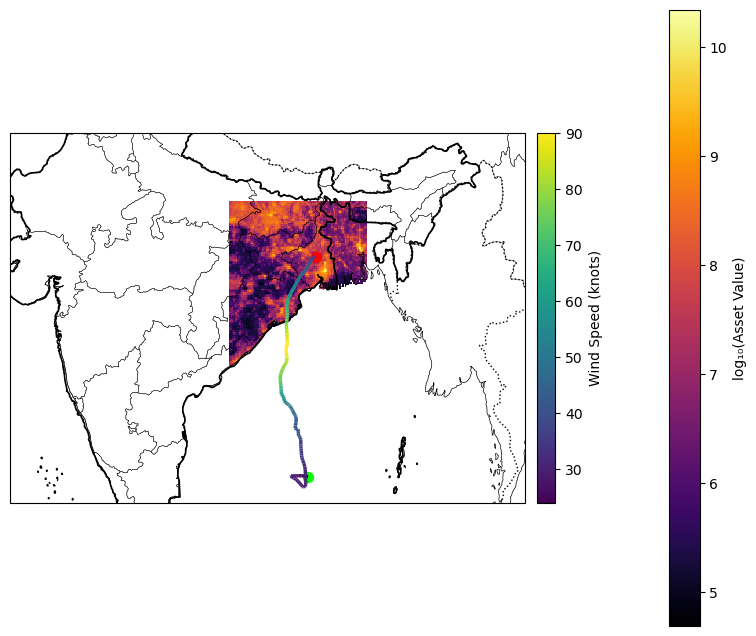

In [2]:
# 📘 Section 1: Setup & Imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np, matplotlib.pyplot as plt, geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs, cartopy.feature as cfeature
from matplotlib.collections import LineCollection

from climada.hazard import TCTracks, TropCyclone, Centroids
from climada.entity import Exposures
from climada.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client

# 🌪️ Section 2: Historical Track Filtering
lat_min, lat_max = 17.0, 23.0
lon_min, lon_max = 81.0, 90.0

tracks_all = TCTracks.from_ibtracs_netcdf(
    provider="usa",
    year_range=(1980, 2023),
    basin="NI",
    estimate_missing=True  # replaces deprecated correct_pres
)

def filter_tracks_by_region(tracks, lat_min, lat_max, lon_min, lon_max):
    selected = []
    for track in tracks.data:
        lats, lons = track['lat'].values, track['lon'].values
        if ((lats >= lat_min) & (lats <= lat_max) & (lons >= lon_min) & (lons <= lon_max)).any():
            selected.append(track)
    return TCTracks(data=selected)

regional_tracks = filter_tracks_by_region(tracks_all, lat_min, lat_max, lon_min, lon_max)
# 🧪 Optional Diagnostic: Track Metadata Audit
print("Available keys:", regional_tracks.data[0].keys())
print("Available attrs:", regional_tracks.data[0].attrs)
print("Track name:", regional_tracks.data[0].name)

# 🖼️ Optional: Custom Plot for Historical Tracks
def extract_track_coords(tracks):
    track_list = []
    for track in tracks.data:
        lons = track['lon'].values
        lats = track['lat'].values
        name = track.name if hasattr(track, 'name') else "Unnamed"
        track_list.append({'name': name, 'lon': lons, 'lat': lats})
    return track_list

def plot_custom_tracks(track_list, title="Historical TCs in Odisha–Bengal"):
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.set_extent([70, 100, 10, 30], crs=ccrs.PlateCarree())

    for track in track_list:
        ax.plot(track['lon'], track['lat'], linewidth=1.2, alpha=0.5, transform=ccrs.PlateCarree())

    ax.set_title(title, fontsize=16)
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

# Generate and plot
track_list = extract_track_coords(regional_tracks)
plot_custom_tracks(track_list)

# 🧪 Section 3: Synthetic Track Generation
regional_tracks.equal_timestep()
regional_tracks.calc_perturbed_trajectories(nb_synth_tracks=5)

# Dynamically select first synthetic track
base_id = regional_tracks.data[0].name  # safer fallback
tc_syn = regional_tracks.get_track(f"{base_id}_gen1")

# 🔥 Section 4: Climate Amplification
def amplify_tc(track_input, intensity_boost=1.2):
    track = track_input[0] if isinstance(track_input, list) else track_input
    track["max_sustained_wind"] *= intensity_boost
    return track

tc_syn_rcp85 = amplify_tc(tc_syn)

# 🗺️ Section 5: LitPop Exposure (Explicit)
def get_litpop_exposure(track, buffer_deg=3.0, countries=["IND", "BGD"]):
    lat_min = track['lat'].min().item() - buffer_deg
    lat_max = track['lat'].max().item() + buffer_deg
    lon_min = track['lon'].min().item() - buffer_deg
    lon_max = track['lon'].max().item() + buffer_deg

    client = Client()
    exposures = []
    for country in countries:
        exp = client.get_litpop(country=country)
        gdf = exp.gdf.copy()
        gdf['lat'] = gdf.geometry.y
        gdf['lon'] = gdf.geometry.x
        gdf_filtered = gdf[
            (gdf['lat'] >= lat_min) & (gdf['lat'] <= lat_max) &
            (gdf['lon'] >= lon_min) & (gdf['lon'] <= lon_max)
        ].copy()
        exposures.append(Exposures(gdf_filtered))

    exp_combined = Exposures.concat(exposures)
    exp_combined.gdf['lat'] = exp_combined.gdf.geometry.y
    exp_combined.gdf['lon'] = exp_combined.gdf.geometry.x
    return exp_combined

exposure = get_litpop_exposure(tc_syn_rcp85)
print("Exposure columns:", exposure.gdf.columns.tolist())
print(exposure.gdf.head())

# 📊 Section 6: CCART Impact Pipeline
def generate_hazard(track, exposure):
    lat = exposure.gdf['lat'].values
    lon = exposure.gdf['lon'].values
    centroids = Centroids(lat=lat, lon=lon)
    track_container = TCTracks()
    track_container.data = [track]
    return TropCyclone.from_tracks(track_container, centroids=centroids)

def assign_impact_function(exposure):
    impf = ImpfTropCyclone.from_emanuel_usa()
    impf_set = ImpactFuncSet([impf])
    haz_type = impf_set.get_hazard_types()[0]
    haz_id = impf_set.get_ids()[haz_type][0]
    exposure.gdf["impf_" + haz_type] = haz_id
    exposure.impact_funcs = impf_set
    return impf_set

def compute_impact(exposure, impf_set, hazard):
    return ImpactCalc(exposure, impf_set, hazard).impact()

def extract_impact_gdf(impact, threshold=1e6):
    from scipy.sparse import find
    row, col, val = find(impact.imp_mat)
    lat = impact.coord_exp[:, 0][col]
    lon = impact.coord_exp[:, 1][col]
    gdf = gpd.GeoDataFrame({
        'impact_usd': val,
        'latitude': lat,
        'longitude': lon
    }, geometry=[Point(xy) for xy in zip(lon, lat)], crs="EPSG:4326")
    return gdf[gdf['impact_usd'] > threshold]

# 🖼️ Section 7: Plot Impact
def plot_tc_impact(track, gdf_litpop, gdf_impact, title="TC Impact",
                   wind_var="max_sustained_wind", zoom_buffer=2.0):
    track_lats = track['lat'].values
    track_lons = track['lon'].values
    track_wind = track[wind_var].values
    points = np.array([track_lons, track_lats]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(
        segments,
        cmap='plasma',
        norm=plt.Normalize(track_wind.min(), track_wind.max()),
        linewidth=2.5,
        array=track_wind,
        transform=ccrs.PlateCarree()
    )

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    gdf_litpop.plot(ax=ax, color='lightblue', markersize=1.5, alpha=0.4,
                    label='LitPop Exposure', transform=ccrs.PlateCarree())
    gdf_impact.plot(ax=ax, column='impact_usd', cmap='plasma', markersize=6,
                    legend=True, legend_kwds={'label': "Impact (USD)", 'shrink': 0.6},
                    transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    cbar = plt.colorbar(lc, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label("Wind Speed (knots)")
    ax.set_extent([
        gdf_impact['longitude'].min() - zoom_buffer,
        gdf_impact['longitude'].max() + zoom_buffer,
        gdf_impact['latitude'].min() - zoom_buffer,
        gdf_impact['latitude'].max() + zoom_buffer
    ], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14)
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

print("Synthetic track name:", tc_syn_rcp85.name)
print("Wind values:", tc_syn_rcp85["max_sustained_wind"].values)
print("Exposure points:", len(exposure.gdf))

# 🚀 Final Execution Block
hazard = generate_hazard(tc_syn_rcp85, exposure)
impf_set = assign_impact_function(exposure)
impact = compute_impact(exposure, impf_set, hazard)
gdf_impact = extract_impact_gdf(impact)

# Plot the synthetic TC impact
plot_tc_impact(tc_syn_rcp85, exposure.gdf, gdf_impact, title="Synthetic TC Impact (RCP8.5)")
print("Impact matrix shape:", impact.imp_mat.shape)

# 📍 Section 8: Standalone Impact Visualization & Pattern Interpretation
def plot_impact_points(gdf_impact, title="High-Impact Zones (USD > 1M)"):
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    gdf_impact.plot(ax=ax, column='impact_usd', cmap='inferno', markersize=6,
                    legend=True, legend_kwds={'label': "Impact (USD)", 'shrink': 0.6},
                    transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the standalone impact plot
plot_impact_points(gdf_impact)

# 🧪 Pattern Interpretation
print("Max impact value (USD):", gdf_impact['impact_usd'].max())
print("Number of high-impact zones:", len(gdf_impact))
print("Mean impact value (USD):", gdf_impact['impact_usd'].mean())

# Optional: Check if impacts cluster near known cities
print("Impact lat range:", gdf_impact['latitude'].min(), "-", gdf_impact['latitude'].max())
print("Impact lon range:", gdf_impact['longitude'].min(), "-", gdf_impact['longitude'].max())

# 🗺️ Section 9: Rasterized LitPop Visualization
# 🗺️ Load Custom Boundary for India
india_boundary = gpd.read_file(r"C:\CMIP data\cmip6\Climada\Country Shape Files\India\india_India_Country_Boundary.shp")
india_boundary = india_boundary.to_crs("EPSG:4326")

from scipy.stats import binned_statistic_2d

def rasterize_litpop_with_tc(exposure, boundary_gdf, track, bins=100, title="LitPop Exposure + TC Track (log₁₀ scale)"):
    lat = exposure.gdf['lat'].values
    lon = exposure.gdf['lon'].values
    values = exposure.gdf['value'].values

    # Avoid log(0) by setting a minimum threshold
    values = np.where(values <= 0, 1, values)
    log_values = np.log10(values)

    stat_result, x_edge, y_edge, _ = binned_statistic_2d(
        lon, lat, log_values, statistic='mean', bins=bins
    )

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([70, 100, 10, 30], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3)

    # Rasterized LitPop
    mesh = ax.pcolormesh(x_edge, y_edge, stat_result.T, cmap='inferno', transform=ccrs.PlateCarree())
    plt.colorbar(mesh, ax=ax, label="log₁₀(Asset Value)")

    # Overlay India boundary
    boundary_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2, transform=ccrs.PlateCarree())

    # Overlay TC track
    from matplotlib.collections import LineCollection

    # Extract TC track coordinates and wind speeds
    track_lons = track['lon'].values
    track_lats = track['lat'].values
    track_wind = track['max_sustained_wind'].values

    # Create segments for gradient line
    points = np.array([track_lons, track_lats]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # LineCollection with wind speed gradient
    lc = LineCollection(
        segments,
        cmap='viridis',  # ← changed from 'plasma'
        norm=plt.Normalize(track_wind.min(), track_wind.max()),
        linewidth=2.5,
        array=track_wind,
        transform=ccrs.PlateCarree()
    )

    # Add to plot
    ax.add_collection(lc)
    cbar = plt.colorbar(lc, ax=ax, orientation='vertical', shrink=0.6, pad=0.02)
    cbar.set_label("Wind Speed (knots)")

    # Mark start and end points
    ax.scatter(track_lons[0], track_lats[0], color='lime', s=50, label='Start', transform=ccrs.PlateCarree())
    ax.scatter(track_lons[-1], track_lats[-1], color='red', s=50, label='End', transform=ccrs.PlateCarree())



# Call the rasterized LitPop plot
rasterize_litpop_with_tc(exposure, india_boundary, tc_syn_rcp85)



